In [86]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import average_precision_score

In [2]:
# Download dataset
!kaggle datasets download 'sgpjesus/bank-account-fraud-dataset-neurips-2022' --unzip

100%|███████████████████████████████████████▉| 545M/546M [00:19<00:00, 29.8MB/s]
100%|████████████████████████████████████████| 546M/546M [00:19<00:00, 29.8MB/s]


In [262]:
# Load base dataset
df = pd.read_csv('Base.csv')

In [263]:
# Delete feature with same value for all instances
df.drop(columns=['device_fraud_count'], inplace=True)

In [264]:
# Classifying features as numerical, categorical or binary
numerical = ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes', 'device_distinct_emails_8w', 'month']
categorical = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
binary = ['fraud_bool', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'foreign_request', 'keep_alive_session', 'has_other_cards']

In [265]:
# Splitting the dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fraud_bool
y_val = df_val.fraud_bool
y_test = df_test.fraud_bool
y_full_train = df_full_train.fraud_bool

del df_train['fraud_bool']
del df_val['fraud_bool']
del df_test['fraud_bool']
del df_full_train['fraud_bool']

In [40]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

X_train_cat = ohe.fit_transform(df_train[categorical].values)
print(X_train_cat.shape)
X_val_cat = ohe.fit_transform(df_val[categorical].values)

X_train_num = np.column_stack([df_train[numerical], df_train[binary[1:]]])
print(X_train_num.shape)
X_val_num = np.column_stack([df_val[numerical], df_val[binary[1:]]])

X_train = np.column_stack([X_train_num, X_train_cat])
print(X_train.shape)
X_val = np.column_stack([X_val_num, X_val_cat])

(600000, 26)
(600000, 25)
(600000, 51)


In [23]:
model = LogisticRegression(solver='liblinear', C=0.1, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

In [24]:
average_precision_score(y_val, y_pred)

0.8608374230433867

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [266]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')
full_train_dicts = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)
X_full_train = dv.transform(full_train_dicts)

In [73]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

In [74]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = average_precision_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = average_precision_score(y_val, y_pred)
print('val:', auc)

train: 0.8259436159401365
val: 0.817905052519907


In [75]:
feature_names = list(dv.get_feature_names_out())

In [ ]:
print(export_text(dt, feature_names=feature_names))

In [88]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = average_precision_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.026
   2 -> 0.036
   3 -> 0.051
   4 -> 0.061
   5 -> 0.071
   6 -> 0.078
  10 -> 0.079
  15 -> 0.058
  20 -> 0.034
None -> 0.017


In [ ]:
scores = []

for depth in [10, 11, 12]:
    for s in [200, 300, 400, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = average_precision_score(y_val, y_pred)
        
        scores.append((depth, s, auc))
        print((depth, s, auc))

In [ ]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

In [ ]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [99]:
from sklearn.ensemble import RandomForestClassifier


In [101]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    score = average_precision_score(y_val, y_pred)
    
    scores.append((n, score))

0.120398355367826

In [102]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])


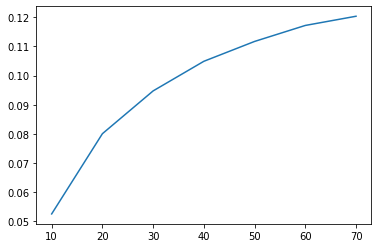

In [103]:
plt.plot(df_scores.n_estimators, df_scores.auc)


In [104]:
import xgboost as xgb


In [142]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [267]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)

In [218]:
scores = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [166]:
def generate_params(eta, max_depth, min_child_weight):
    
    xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'nthread': 16,
    
    'seed': 1,
    'verbosity': 1,
}
    return xgb_params

In [203]:
def train_xgb(xgb_params, n_boost):
    model = xgb.train(xgb_params, dtrain, num_boost_round=n_boost, verbose_eval=5, evals=watchlist)

In [219]:
%%capture output
xgb_params = generate_params(1, 8, 1)
train_xgb(xgb_params, 20)
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

In [220]:
%%capture output
xgb_params = generate_params(1, 10, 1)
train_xgb(xgb_params, 20)
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

In [221]:
%%capture output
xgb_params = generate_params(1, 12, 1)
train_xgb(xgb_params, 20)
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

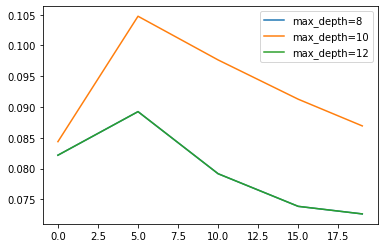

In [222]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()

In [224]:
scores = {}

In [225]:
%%capture output
xgb_params = generate_params(1, 10, 1)
train_xgb(xgb_params, 20)
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

In [226]:
%%capture output
xgb_params = generate_params(1, 10, 10)
train_xgb(xgb_params, 20)
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

In [227]:
%%capture output
xgb_params = generate_params(1, 10, 30)
train_xgb(xgb_params, 20)
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

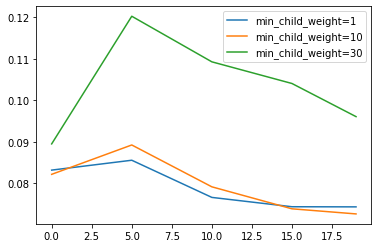

In [228]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.legend()

In [233]:
# Final model
xgb_params = {
    'eta': 1, 
    'max_depth': 10,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'nthread': 16,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=5, verbose_eval=5, evals=watchlist)

[0]	train-aucpr:0.11744	val-aucpr:0.09070
[4]	train-aucpr:0.21004	val-aucpr:0.13161


In [234]:
y_pred = model.predict(dval)

In [235]:
roc_auc_score(y_val, y_pred)

0.8676703531525642

In [236]:
average_precision_score(y_val, y_pred)

0.13195876344665855

In [269]:
watchlist = [(dtrain, 'train'), (dtest, 'test')]

In [271]:
model = xgb.train(xgb_params, dfulltrain, num_boost_round=5, verbose_eval=5, evals=watchlist)

[0]	train-aucpr:0.12023	test-aucpr:0.09743
[4]	train-aucpr:0.20500	test-aucpr:0.13439


In [272]:
y_pred = model.predict(dtest)

In [273]:
roc_auc_score(y_test, y_pred)

0.8684313780116187

In [274]:
average_precision_score(y_test, y_pred)

0.13467773387570825